# Data Exploration, Visualization and Processing. Model Development and Deployment

This notebook is a one-stop-shop for replicating the project results. It will serve as the project development environment. Please refer to the `README` to get a background on the project and to understand its objectives. 

The image below gives a high level architecture of the various steps involved in this notebook:

### High level Process Flow
<img src=Project_Workflow.png width=90% />

To run this notebook, follow these instructions:
- git clone the repository at https://github.com/pharouhk/Querying-and-forecasting-with-Natural-Language.git to quickly pull all the project dependencies
- make sure that your Python environment has both TensorFlow and PyTorch installed
- It is important to also note this notebook was developed using AWS Sagemaker, so an AWS profile and access to compute instances is required

### Initialization 

In [ ]:
!pip install transformers

!pip install pytorch-lightning

!pip install sentencepiece

     |████████████████████████████████| 3.1 MB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 59.0 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 3.3 MB 65.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 925 kB 51.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 75.4 MB/s eta 0:00:01
     |████████████████████████████████| 329 kB 69.1 MB/s eta 0:00:01
     |████████████████████████████████| 881.9 MB 265 bytes/s a 0:00:01     |██████████████▊                 | 406.5 MB 65.2 MB/s eta 0:00:08     |███████████████████▍            | 535.7 MB 82.2 MB/s eta 0:00:05     |██████████████████████████▏     | 721.3 MB 36.9 MB/s eta 0:00:05     |██████████████████████████▎     | 724.8 MB 36.9 MB/s eta 0:00:05     |██████████████████████████████▊

In [4]:
#import necessary libraries and instantiate AWS-specific variables
import pandas as pd
import boto3
import sagemaker
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
# import json for formatting data
import json

#libraries for Pretrained model
from transformers import AutoModelWithLMHead, AutoTokenizer
import random, warnings

warnings.filterwarnings("ignore")

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## Reading in the Custom Data

### Brief Description of the Datasets

This is a supervised learning task and each dataset comes with target labels. Two types of datasets will be employed in this project. One is the training dataset and the other is a custom dataset. Both datasets are described below:

1.	**Training Dataset**: The **SparC** dataset that we would be used to train our model. The SParC dataset is a multi-domain or multi-context dataset that contains over **200 databases from over 100 different domains**. The dataset was developed by Yale & Salesforce from about 12K unique coherent questions from user interactions in those various domains. The dataset is one of the most used and widely cited for the text to SQL challenge and currently maintains a leaderboard of the most “state-of-the-art” models built on its dataset. The dataset can be downloaded from the official page of the challenge (https://yale-lily.github.io/sparc)
2.	**Custom Dataset**: This is the dataset that will be used to test and tune our model. This database would be used to test our model’s text-to-SQL conversion performance on the new schema; it is a data set containing price information of Bitcoin. This is the data that would mostly be explored and visualized in this notebook.

In [5]:
file_path = 'data/custom/gemini_BTCUSD_2020_1min.csv'
custom_df = pd.read_csv(file_path)

custom_df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


## Data Exploration

In [180]:
custom_df.shape

(658065, 8)

*The dataset has over 650K records*

In [181]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658065 entries, 0 to 658064
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  658065 non-null  float64
 1   Date            658065 non-null  object 
 2   Symbol          658065 non-null  object 
 3   Open            658065 non-null  float64
 4   High            658065 non-null  float64
 5   Low             658065 non-null  float64
 6   Close           658065 non-null  float64
 7   Volume          658065 non-null  float64
dtypes: float64(6), object(2)
memory usage: 40.2+ MB


*There is no missing data*

**What is the time window being considered in the data?**

In [182]:
end_date = list(custom_df.Date)[0]
start_date = list(custom_df.Date)[-1]
print ("The time frame of the Dataset is between {} and {}". format(start_date, end_date))

The time frame of the Dataset is between 1/1/2020 0:00 and 4/20/2021 0:02


**What is the highest Bitcoin closing price and when did it occur?** 

PS: at the end of the notebook these exploratory questions can be asked directly via the web app

In [183]:
max_price = max(list(custom_df.Close))
max_price_date = custom_df[custom_df.Close == max_price].Date
print ("The maximum price of BTC was {}USD and this occurred on {}". format(max_price, list(max_price_date)[0]))

The maximum price of BTC was 64890.0USD and this occurred on 4/14/2021 6:13


## Data Visualization

**Let's see how the price of Bitcoin has varied over time**

It is important to take cognizance of the size of the data - >650K records - which is a minute by minute record of Bitcoin's price. For this project, we want to understand the hourly trend and predict Bitcoin prices in the couple of hours therefore, we would aggregate the data on an hourly basis and average the prices within each hour.

### Data Aggregation

In [6]:
#first convert the date to pandas datetime
custom_df["Date"] = pd.to_datetime(custom_df['Date'], format='%m/%d/%Y %H:%M')

In [7]:
custom_date = custom_df["Date"].dt.date #retains the date part only
custom_hour = custom_df["Date"].dt.hour #retains the hour part only

# concatenate the date and hour
custom_dt_hour = [str(date)+ '  ' +str(hour)+ ':00:00' if hour > 9 else str(date)+ '  ' + '0'+str(hour)+ ':00:00' for date,
                  hour in zip(custom_date, custom_hour)] 
#assigns to a column
custom_df["Date_Hour"] = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in custom_dt_hour]

In [8]:
custom_df_agg = pd.pivot_table(custom_df, values=['Close', 'Volume'], index=['Date_Hour'],
                               aggfunc={'Close': 'mean','Volume': 'mean'})
custom_df_agg.shape

(10987, 2)

In [187]:
custom_df_agg.head()

,Close,Volume
Date_Hour,,
2020-01-01 00:00:00,7154.573000,1.858578
2020-01-01 01:00:00,7178.335833,2.123790
2020-01-01 02:00:00,7207.665667,2.024427
2020-01-01 03:00:00,7205.175333,0.424062
2020-01-01 04:00:00,7194.898333,0.701623


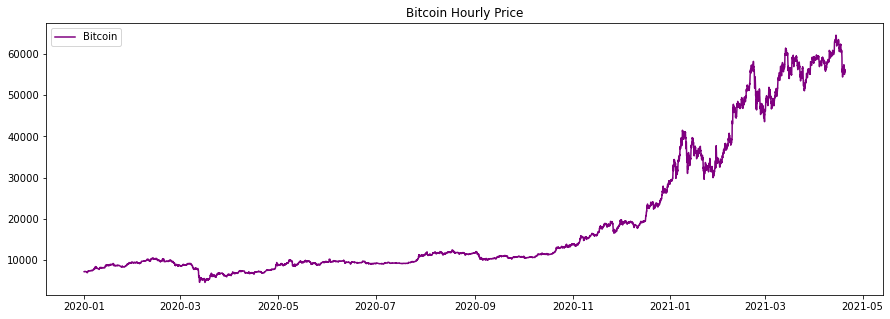

In [34]:
plt.figure(figsize=[15,5])
plt.plot(custom_df_agg["Close"] , color = 'Purple', label = 'Bitcoin')
plt.legend(loc='best')
plt.title('Bitcoin Hourly Price')
plt.show()

### Baseline Modelling - ARIMA Statistical Model

This project will test the ARIMA model to establish the baseline performance. ARIMA is a very popular statistical model for time series forecasting. Two critical steps are involved here: 
1. Test the Bitcoin closing price for stationarity using **Augmented Dickley-Fuller Test (ADF)**
2. Adjust the price to become stationary if non-stationary

#### ADF Test for Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
   
    print(dfoutput)

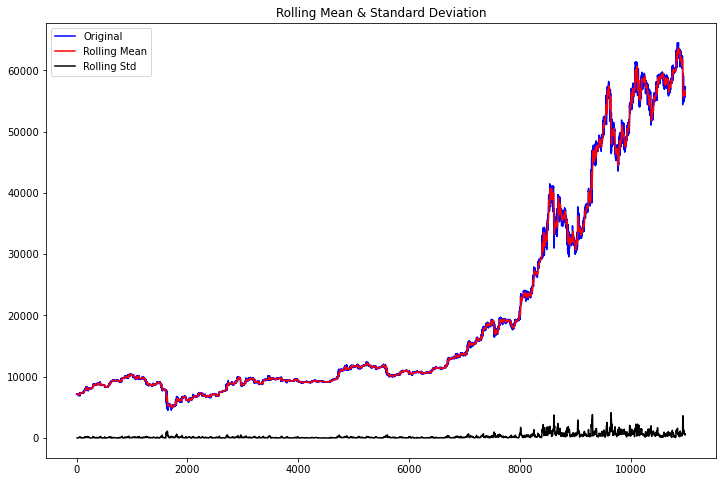

Results of Dickey-Fuller Test:
p-value = 0.9969. The series is likely non-stationary.
Test Statistic                     1.358134
p-value                            0.996915
#Lags Used                        20.000000
Number of Observations Used    10966.000000
Critical Value (1%)               -3.430946
Critical Value (5%)               -2.861804
Critical Value (10%)              -2.566910
dtype: float64


In [16]:
closing_price = custom_df_agg['Close']
test_stationarity(closing_price)

Bitcoin is a non-stationary series hence we need to difference it to achieve stationarity

In [17]:
### DIFFERENCE & INVERSE DIFFERENCE FUNCTIONS

# create a differenced series
def difference(dataset, interval=1):
    '''Returns a time differenced dataset.
       :param dataset: the time series to be differenced.
       :return: The differenced time series.
       '''
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced value to it's original value
def inverse_difference(history, yhat, interval=1):
    '''Returns the price from a time differenced value.
       :param history: the last known time series before the value to be inversed.
       :param yhat: the differenced value to be inversed.
       :Default param interval: the inverse time interval.
       :return: The inversed time differenced value (the original price).
       '''
    
    return yhat + history[-interval]

In [18]:
custom_df_agg['Close_diff'] = [0] + difference(custom_df_agg['Close'], interval=1)

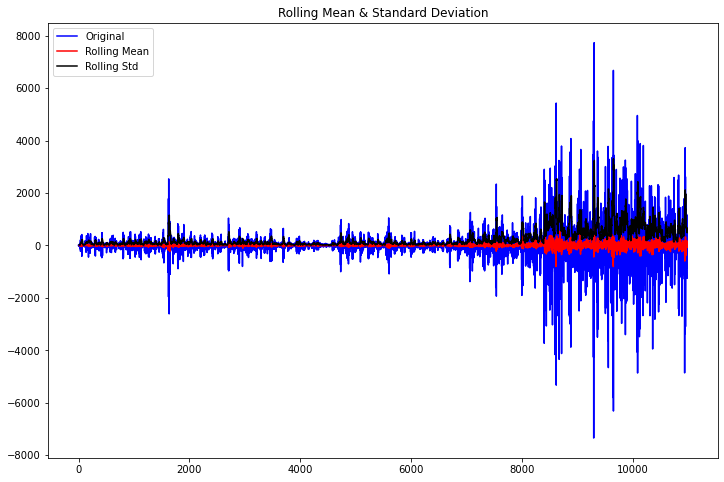

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -28.740895
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    10966.000000
Critical Value (1%)               -3.430946
Critical Value (5%)               -2.861804
Critical Value (10%)              -2.566910
dtype: float64


In [19]:
test_stationarity(custom_df_agg['Close_diff'])

Text(0.5, 1.0, 'Partial Autocorrelation BTC price')

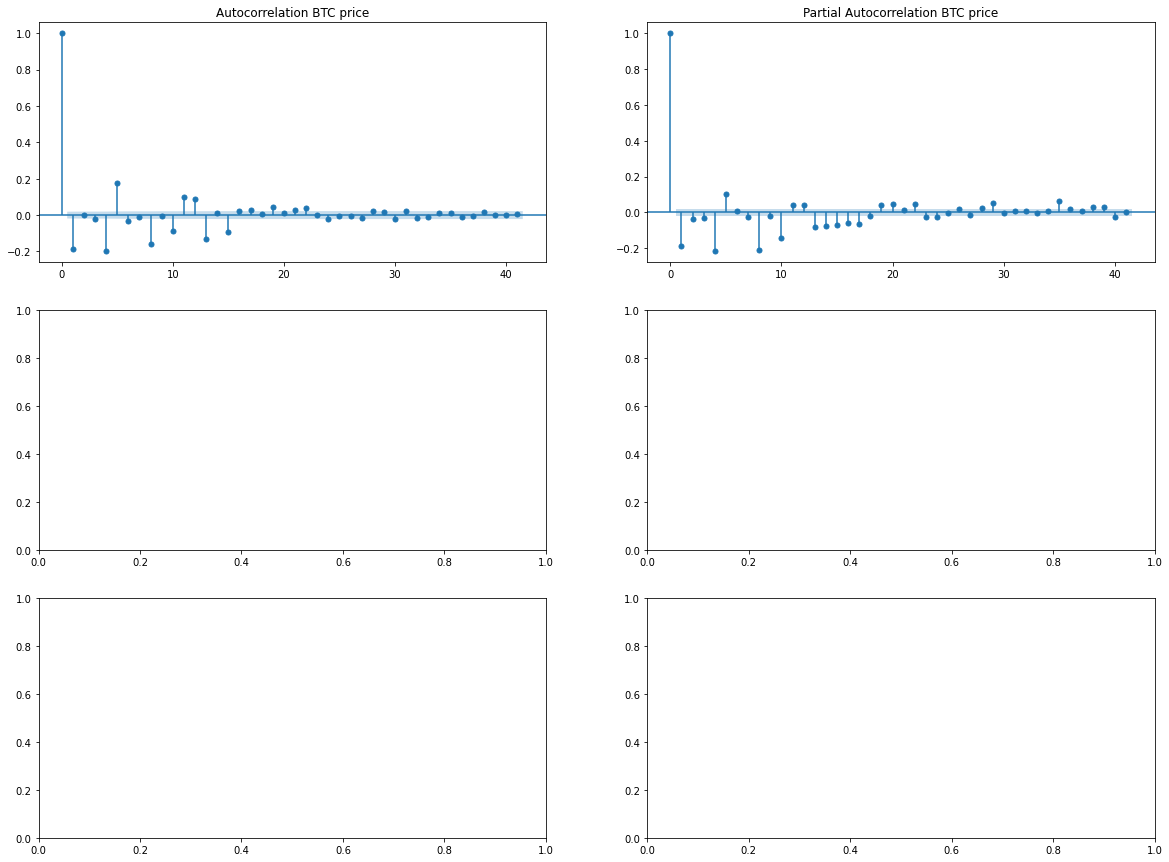

In [20]:
fig, ax = plt.subplots(3,2,figsize=(20,15))
sm.graphics.tsa.plot_acf(custom_df_agg['Close_diff'], ax=ax[0, 0])
ax[0, 0].set_title('Autocorrelation BTC price')
sm.graphics.tsa.plot_pacf(custom_df_agg['Close_diff'], ax=ax[0, 1])
ax[0, 1].set_title('Partial Autocorrelation BTC price')

**Model Choice:** As seen in ACF and PACF charts above, the following ARIMA model of order (1,1,1) would be employed. 

**This means the previous data point is the most improtant variable for forecasting the next price - Autoregressive** 

### Model Training

Simialr to other Machine Learning tasks, the data would be trained and validated on a train and validation set respectively. The only difference is that the ARIMA model would be trained recursively and compared to validation data point because of the order of the model --> AR (1) and MA (1)

In [63]:
## creating the dataset

# train_data
train_arima = list(custom_df_agg['Close_diff'][:10700])
train_data = list(custom_df_agg['Close'][:10700])

#validation data
val_arima = list(custom_df_agg['Close_diff'][10700:10900])
val_data = list(custom_df_agg['Close'][10700:10900])

#test data -the model would be tested on a few data points
test_arima = list(custom_df_agg['Close_diff'][10900:])
test_data = list(custom_df_agg['Close'][10900:])

In [69]:
#training function

def train_model(train, val, train_prices, val_prices, order=(1,1,1)):
    '''Returns an autoregressively trained model for bitcoin price prediction and predicted prices.
       :param train: A time differenced training set time series of bitcoin closing price.
       :param val: A time differenced validation set time series of bitcoin closing price.
       :param train_prices: A training set time series of bitcoin closing price.
       :param val_prices: A validation set time series of bitcoin closing price.
       :Default param val_prices: the order of the model. Default is (1,1,1).
       :return 1: A trained model.
       :return 2: A list of predicted prices from the model.
       '''
    
    prediction_prices = []
    known_history = train_prices
    for i in range (len(val)):
        #re-trainning the model with new info
        ## instantiate and fit the model
        btc_model = ARIMA(train, order=order).fit()

        # one-step out-of sample forecast
        forecast = btc_model.forecast(1)[0]

        # invert the differenced forecast to get the price
        forecast_price = inverse_difference(known_history, forecast, 1)
        prediction_prices.append(forecast_price)
        
        #update the historical prices and train data for retraining and differencing respectively
        known_history = known_history + [val_prices[i]]
        train = train + [val[i]]
        
    #get the latest model to be reused
#     updated_btc_model = ARIMA(train + val, order=order).fit()
    return btc_model, prediction_prices

In [70]:
%%time
model, pred = train_model(train_arima, val_arima, train_data, val_data, order=(1,1,1))

CPU times: user 8min 15s, sys: 2 s, total: 8min 17s
Wall time: 7min 37s


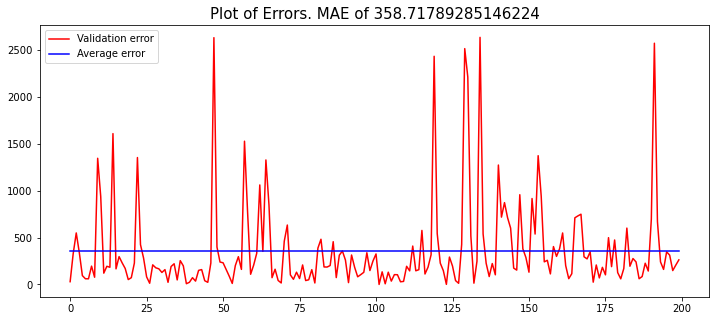

In [85]:
## see how the errors trended on the validation set
validation_errors = [abs(v-p) for v, p in zip(val_data, pred)]
mae = mean_absolute_error(val_data, pred)
plt.figure(figsize=(12,5))
plt.plot(validation_errors, color='red',label='Validation error')
plt.plot([mae]*len(pred), color='blue', label = 'Average error')
plt.legend(loc='upper left')
plt.title('Plot of Errors. MAE of {0}'.format(mae), fontsize=15)
plt.show()

There appears to be a few spikes in prediction error

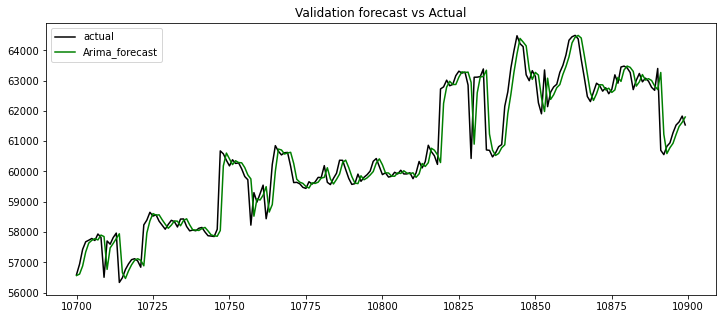

In [82]:
#plot the predictions

#first make into a series
train_plot = custom_df_agg['Close'][:10700]
target_val_plot = custom_df_agg['Close'][10700:10900]
arima_forecast_plot = pd.Series(pred, index = target_val_plot.index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(train_plot, color='red',label='training')
plt.plot(target_val_plot, color='black', label='actual')
plt.plot(arima_forecast_plot, color='green', label='Arima_forecast')
plt.title('Validation forecast vs Actual')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [102]:
#forecast for the next 87 hours in the test data and evaluate performance
test_pred = model.forecast(steps=len(test_arima), alpha=0.05) #95% confidence interval

#convert the time differenced forecastes to bitcoin prices
test_prices = []
test_known_history = val_data 
for i, pred in enumerate(test_pred):
    price = inverse_difference(test_known_history, pred, 1)
    test_known_history = test_known_history + [price]
    test_prices.append(price)

In [103]:
print("Test MAE is {0}".format(mean_absolute_error(test_data, test_prices)))

Test MAE is 3442.3212551214274


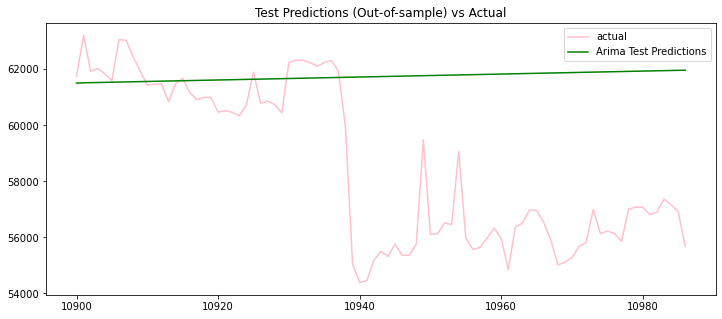

In [104]:
target_plot = custom_df_agg['Close'][10900:]
arima_prediction_plot = pd.Series(test_prices, index= target_plot.index)

plt.figure(figsize=(12,5))
# plt.plot(train_plot, color='red',label='training')
plt.plot(target_plot, color='pink', label='actual')
plt.plot(arima_prediction_plot, color='green', label='Arima Test Predictions')
plt.title('Test Predictions (Out-of-sample) vs Actual')
plt.legend(loc='best', fontsize=10)
plt.show()

**Key takeaway from the baseline model**: From the figure above, it is apparent that the ARIMA model cannot account for big shocks in the BTC price as there are so many other exogeneous factors that impact price movements hence the **we can establish a prediction length of not more than one week (24hours x 7 days) for our eventual served model**

## Time Series Forecasting - DeepAR Estimator

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
The start and end dates of our data have been explored before and they are 1/1/2020 0:00 and 4/20/2021 0:02 respectively

#### Create the Training and Test Time series

The training timeseries would be the complete time series albeit the prediction length. The test time series or better referred to as target is the complete timeseries. It is useful to run the first cell below. It ensures your data has index for every hour which is useful during predictions as you would see below. Also note, the dataset would be increased and you can fill the missing data with the average btc price

In [9]:
##run this cell
custom_df_agg = custom_df_agg.asfreq('H').fillna(np.mean(custom_df_agg['Close']))

In [10]:
custom_df_agg.shape

(11401, 2)

In [11]:
#set the training start date
start_date = custom_df_agg.index[0]
end_date = custom_df_agg.index[-1]

#set the context and prediction length
context_length = 168 #one week of hourly data
prediction_length = 168 #one week of hourly data

In [12]:
training_series = custom_df_agg['Close'][:-prediction_length]
test_series = custom_df_agg['Close']

*convert the pandas Series object to json*

In [192]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :param s_date: the time series start_date.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [193]:
##test the function
series_to_json_obj(training_series[0:5])

{'start': '2020-01-01 00:00:00',
 'target': [7154.572999999998,
  7178.335833333332,
  7207.665666666668,
  7205.175333333334,
  7194.898333333335]}

**convert the entire data and save locally** 

In [194]:
##first create the necessary directories and filenames
data_dir = 'json_btc_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# directories to save train/test data
train_path = os.path.join(data_dir, 'train.json')
test_path = os.path.join(data_dir, 'test.json')

In [195]:
##helper function for writing and saving the json object to a file
def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        json_line = json.dumps(series_to_json_obj(time_series)) + '\n'
        json_line = json_line.encode('utf-8')
        f.write(json_line)
    print(filename + ' saved.')

In [196]:
# write the train/test JSON files using the above helper function
write_json_dataset(training_series, train_path)        
write_json_dataset(test_series, test_path)

json_btc_data/train.json saved.
json_btc_data/test.json saved.


**Upload to S3 bucket where DeepAR can access during training**

In [197]:
# the prefix for S3. Similar to data directory
prefix='deepar-btc-data'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_path, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_path,  bucket=bucket, key_prefix=test_prefix)

#check if everything was uploaded correctly
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-005426805090/deepar-btc-data/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-005426805090/deepar-btc-data/test/test.json


### Training DeepAR

In [198]:
##configure the image
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [199]:
image_name

'522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1'

In [200]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_uri=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [201]:
##set the model hyperparameters
hyperparameters = {
    "epochs": "50",
    "time_freq": 'H',
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)

**Start the training Job** 

In [202]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2021-10-22 07:09:59 Starting - Starting the training job...
2021-10-22 07:10:27 Starting - Launching requested ML instancesProfilerReport-1634886599: InProgress
......
2021-10-22 07:11:27 Starting - Preparing the instances for training...............
2021-10-22 07:13:48 Downloading - Downloading input data...
2021-10-22 07:14:28 Training - Training image download completed. Training in progress.Arguments: train
[10/22/2021 07:14:26 INFO 140662060397952] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.

**deploy the endpoint to evaluate the predictions**

To ease the data serialization and deserialization, the predictor helper class comes in handy.Most importantly it allows time series to be passed directly to the predictor endpoint for predictions. 

In [211]:
##view content of the predict_helper class
!pygmentize Predictor_helper.py

import sagemaker
#for predictions
from sagemaker.serializers import IdentitySerializer
import numpy as np
import os
import json
import pandas as pd

class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction 

In [2]:
from sagemaker.serializers import IdentitySerializer

In [247]:
%%time
#this enables us do predictions in timeseries format
import Predictor_helper

# create a predictor
predictor_with_series = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    predictor_cls=Predictor_helper.DeepARPredictor
)

-------------------!CPU times: user 328 ms, sys: 4.42 ms, total: 333 ms
Wall time: 9min 33s


### Getting Predictions from the deployed endpoint

We would do this by evaluating the performance of the training job against the actual 

In [214]:
# get formatted input time series
# json_input_series = json_predictor_input(training_series)

# get the prediction from the predictor
json_prediction = predictor_with_series.predict(training_series)

In [215]:
json_prediction

,0.1,0.5,0.9
2021-04-13 01:00:00,58763.816406,60680.191406,62623.761719
2021-04-13 02:00:00,58700.953125,60606.050781,62139.589844
2021-04-13 03:00:00,58654.406250,60689.566406,63258.222656
2021-04-13 04:00:00,58536.320312,60874.402344,62889.742188
2021-04-13 05:00:00,58641.378906,60855.796875,62696.144531
...,...,...,...
2021-04-19 20:00:00,61749.179688,66709.898438,71677.796875
2021-04-19 21:00:00,62615.746094,66462.125000,71877.054688
2021-04-19 22:00:00,61578.500000,66311.882812,71483.281250
2021-04-19 23:00:00,61755.523438,65936.132812,72016.882812


In [217]:
MAE = mean_absolute_error(test_series[len(test_series)-prediction_length:], json_prediction['0.9'])
print ('DeepAR MAE: {0}'.format(MAE))

DeepAR MAE: 8362.860700619185


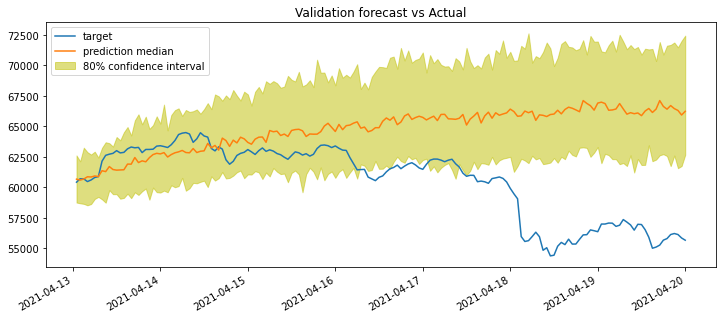

In [219]:
p10 = json_prediction['0.1']
p90 = json_prediction['0.9']
p50 = json_prediction['0.5']
target = test_series[-prediction_length:]
# Plot
plt.figure(figsize=(12,5))
plt.plot(target, label='target')
plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
p50.plot(label='prediction median')
plt.title('Validation forecast vs Actual')
plt.legend(loc='upper left', fontsize=10)
plt.show()

**Generate future predictions**

In [226]:
#last known BTC date
test_series[-1:].index[0]

Timestamp('2021-04-20 00:00:00', freq='H')

In [251]:
future_predictions = predictor_with_series.predict(test_series[-168:])

*we expect predictions to start from the next hour - 2021-04-20 01:00:00*

In [252]:
future_predictions

,0.1,0.5,0.9
2021-04-20 01:00:00,56088.734375,58317.320312,60100.203125
2021-04-20 02:00:00,54691.511719,57321.152344,58765.347656
2021-04-20 03:00:00,56057.148438,57359.058594,59066.523438
2021-04-20 04:00:00,55494.062500,57067.039062,58871.593750
2021-04-20 05:00:00,55087.394531,57153.105469,58725.136719
...,...,...,...
2021-04-26 20:00:00,62779.386719,65508.078125,68450.757812
2021-04-26 21:00:00,63437.273438,65668.570312,68347.679688
2021-04-26 22:00:00,63227.355469,65374.988281,68727.890625
2021-04-26 23:00:00,62214.464844,65522.027344,68588.437500


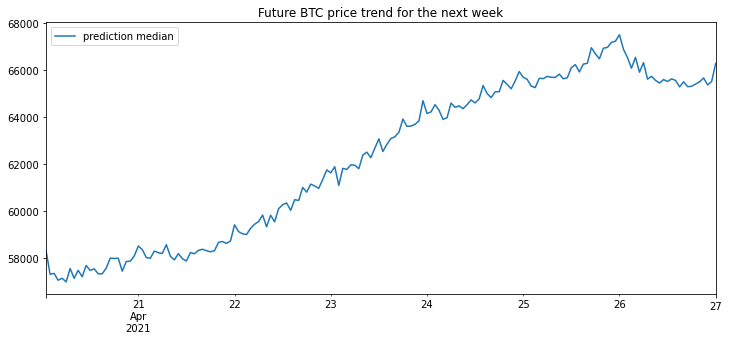

In [253]:
plt.figure(figsize=(12,5))
future_predictions['0.5'].plot(label='prediction median')
plt.title('Future BTC price trend for the next week')
plt.legend(loc='upper left', fontsize=10)
plt.show()

**delete the endpoint for now**

In [227]:
predictor_with_series.delete_endpoint()

## Section 2 of Model Training: Using Pre-trained text-to-SQL model

A pretrained huggingface model developed on text and corresponding sql output as obtained in the [Wikisql](https://huggingface.co/datasets/wikisql#source-data) database was employed for the text to sql translation task in the project. Huggingface hosts thousands of pretrained models and is currently supported by AWS Sagemaker making it ideal. All that was required was to download the model and the tokenizer from huggingface and deploy for predictions. 

The model is a transformer model called [Google T5](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html), fine-tuned to handle text to sql translation. Visit [here](https://huggingface.co/mrm8488/t5-base-finetuned-wikiSQL) for a detailed description of the model. 

In [5]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-wikiSQL")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-wikiSQL")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [6]:
#data preprocessor for predictions
def get_sql(query):
    
    input_text = "translate English to SQL: %s </s>" % query
    
    features = tokenizer([input_text], return_tensors='pt')

    output = model.generate(input_ids=features['input_ids'], 
               attention_mask=features['attention_mask'])

    return tokenizer.decode(output[0])

In [9]:
get_sql("what is the Highest price of Bitcoin so far?")

'<pad> SELECT MAX Price ( USD ) FROM table</s>'

In [17]:
from sagemaker.huggingface import HuggingFaceModel

hub = {
    'HF_MODEL_ID': 'mrm8488/t5-base-finetuned-wikiSQL',
    'HF_TASK': 'translation'
}

eng_to_sql_model = HuggingFaceModel(
    env=hub,
    role=role,
    transformers_version="4.6", # transformers version used
    pytorch_version="1.7", # pytorch version used
    py_version='py36', # python version used
)

In [18]:
%%time
eng_to_sql_predictor = eng_to_sql_model.deploy(
   initial_instance_count=1,
   instance_type="ml.m5.xlarge"
)

------------!CPU times: user 260 ms, sys: 25 ms, total: 285 ms
Wall time: 6min 2s


In [19]:
data = {
"inputs": "what is the Highest price of Bitcoin so far?"
}

In [20]:
eng_to_sql_predictor.predict(data)

[{'translation_text': 'SELECT MAX Price ( USD ) FROM table'}]

## Section 3: Deploying the models to serve over the internet 

**Redeploy the forecast and the text_to_sql models**: if you haven't deleted the endpoints you can use model.endpoint to retreive the endpoint names to be used in the runtime below. However, if deleted and the endpoint configurations have not been deleted you can create a new endpoint using the existing endpoint configurations using the AWS console

In [21]:
test_query = 'what is the Highest price of Bitcoin so far?'
test_forecast = 'What it is the predicted price of bitcoin in 3 days'

As anticipated, the user questions will be of two types: query about the data and a forecast request. This means the lambda function between the API gateway and the model needs to be able to differentiate the intent of the user, preprocess the data before sending to the right endpoint for response.

Below we will create a basic vocabulary of keywords that customers would use for prediction requests

In [14]:
prediction_vocab = ['prediction', 'forecast', 'predicted', 'predict', 'forecasted', 'guess', 'estimated', 'future']

In [15]:
## little helper function to detect user's intent 
def detect_intent(user_text):
    user_words = user_text.split(' ')
    if any(x in user_words for x in prediction_vocab):
        return 'forecast'
    else:
        return 'query'

In [16]:
#test the function
detect_intent(test_forecast)

'forecast'

In [19]:
#another function to detect the forecast timeline
def get_period(user_text):
    numeric_words_dict = {'one': 1, 'two': 2, 'three': 3, 'four':4, 'five':5, 
                     'six':6, 'seven':7, 'eight':8, 'nine':9, 'ten':10}
    numeric_words_list =  list(numeric_words_dict.keys())
    
    UNITS = {"hour":1, "day":24, "week":24*7, "hours":1, "days":24, "weeks":24*7}
    
    try:
        user_words = user_text.split(' ')
        user_words = [str(numeric_words_dict[wrd]) if wrd in numeric_words_list else wrd for wrd in user_words]

        count = [int(word) for word in user_words if word.isdigit()][0]
        period = [UNITS[word] for word in user_words if word in list(UNITS.keys())][0]
        total_period = count*period
    except:
        total_period = 168

    return total_period

In [20]:
get_period('what is the price forecast for bitcoin in 2 weeks')

336

Now we have developed the various helper functions, the next step is to tie everything together

In [109]:
if detect_intent(test_forecast) =='forecast':
    pred_period = get_period(test_forecast)
    pred_data = test_series[-pred_period:]
else:
    pred_data = test_query

In [39]:
pred_data

Date_Hour
2021-04-17 01:00:00    61897.333333
2021-04-17 02:00:00    62234.418333
2021-04-17 03:00:00    62325.971500
2021-04-17 04:00:00    62323.561000
2021-04-17 05:00:00    62239.075500
                           ...     
2021-04-19 20:00:00    56140.110167
2021-04-19 21:00:00    56224.218167
2021-04-19 22:00:00    56142.364667
2021-04-19 23:00:00    55857.384500
2021-04-20 00:00:00    55676.033333
Freq: H, Name: Close, Length: 72, dtype: float64

We need a library that provides local access to the sagemaker API for working with Amazon services - boto3 (which we have already imported as a dependent library). 
To start with, we need to get a handle to the SageMaker runtime.

In [24]:
runtime = boto3.Session().client('sagemaker-runtime')

In [92]:
response_forecast = runtime.invoke_endpoint(EndpointName = 'deepar-forecast', # The name of the endpoint we created
                                       ContentType = 'application/json',    # The data format that is expected
                                       Body = json.dumps({"instances": 
                                           [{
                                               "start": "2021-04-20 01:00:00", # This is a required field per the documentation
                                               "target": list(pred_data) # This is the guidance for the predictions
                                           }]
                                           })
                                           )

In [111]:
response_from_forecast = response_forecast['Body'].read().decode('utf-8')
# print(response_from_forecast)

In [94]:
#check the length of the predictions
len(json.loads(response_from_forecast)['predictions'][0]["mean"])

168

In [106]:
## this will be copied and pasted in the lambda function
# print(list(test_series[-168:]))

**second endpoint**

In [16]:
json.dumps({'input':test_query})

'{"input": "what is the Highest price of Bitcoin so far?"}'

In [27]:
response_query = runtime.invoke_endpoint(EndpointName = 'Huggingface-endpoint', # The name of the endpoint we created
                                       ContentType = 'application/json',                     # The data format that is expected
                                       Body = json.dumps({'inputs':test_query}))

In [30]:
response_from_query = response_query['Body'].read().decode('utf-8')
print(response_from_query)

[{"translation_text":"SELECT MAX Price ( USD ) FROM table"}]


### Create the Lambda Function 

All we need to do is combine the functions to:
- detect user intent
- preprocess request data depending on intent
- route to the endpoint depending on intent
- return response depending on intent

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3
import json
import re

def detect_intent(user_text):
    prediction_vocab = ['prediction', 'forecast', 'predicted', 'predict', 'forecasted', 'guess', 'estimated', 'future']
    user_words = user_text.split(' ')
    if any(x in user_words for x in prediction_vocab):
        return 'forecast'
    else:
        return 'query'
    
    
def get_period(user_text):
    numeric_words_dict = {'one': 1, 'two': 2, 'three': 3, 'four':4, 'five':5, 
                     'six':6, 'seven':7, 'eight':8, 'nine':9, 'ten':10}
    numeric_words_list =  list(numeric_words_dict.keys())
    
    UNITS = {"hour":1, "day":24, "week":24*7, "hours":1, "days":24, "weeks":24*7}
    #Remove punctutaions from the text using regex
    user_text = re.sub(r'[^\w\s]', '', user_text)
    user_words = user_text.split(' ')
    user_words = [str(numeric_words_dict[wrd]) if wrd in numeric_words_list else wrd for wrd in user_words]

    count = [int(word) for word in user_words if word.isdigit()][0]
    period = [UNITS[word] for word in user_words if word in list(UNITS.keys())]
    if len(period)>0:
        total_period = count*period[0]
    else:
        total_period = 168

    return total_period



def lambda_handler(event, context):
    
    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    test_series = [60430.60300000002, 60711.431000000004, 60698.24950000002, 60481.17850000001, 60614.08449999999, 60817.79716666668, 60887.91800000001, 62153.32916666667, 62632.59866666666, 62726.243166666674, 62794.345833333326, 63015.296500000004, 62831.735666666646, 62875.184, 63165.66616666669, 63312.98933333333, 63249.95383333332, 63281.632499999985, 62854.817999999985, 63113.043166666685, 63115.054000000026, 63135.3625, 63386.35316666667, 63418.74966666666, 63353.27216666666, 63273.87366666664, 63503.846000000005, 63846.28050000001, 64335.70766666665, 64449.40866666668, 64496.22066666665, 64379.10250000002, 63697.90249999999, 63985.46366666666, 64483.33116666666, 64219.57500000002, 64123.87466666665, 63192.552500000005, 62998.33466666669, 63329.42949999999, 63141.189499999986, 62268.08149999998, 61904.91749999999, 62141.369, 62622.80766666666, 62793.86016666667, 62880.14066666666, 63104.98866666667, 62916.77949999999, 62704.34333333333, 63013.93183333333, 63237.49266666667, 62960.62616666665, 63081.551666666666, 62979.951333333316, 62779.30966666666, 62680.77666666665, 62476.86966666668, 62309.079666666665, 62620.67033333333, 62915.249, 62840.23516666667, 62653.41483333336, 62765.706166666656, 62567.85433333333, 62715.17683333333, 63192.09566666666, 63450.296166666674, 63481.15133333335, 63421.60066666665, 63269.454500000014, 63401.798833333334, 63211.087999999996, 63059.95133333331, 63036.327, 62448.611500000006, 61941.723000000005, 61440.55350000002, 61466.30666666668, 61479.531833333334, 60847.90683333332, 60699.22, 60557.204333333335, 60831.1775, 60945.469833333314, 61277.212666666666, 61531.85133333333, 61637.44416666666, 61829.91283333333, 61537.03666666667, 61748.47716666668, 61925.58616666666, 62026.54449999999, 61844.278499999986, 61597.798, 61484.54683333334, 61897.33333333334, 62234.41833333335, 62325.97150000001, 62323.560999999994, 62239.075500000006, 62108.47116666668, 62235.940333333325, 62311.0925, 61941.53749999998, 61675.54899999998, 61172.97933333335, 60914.861999999994, 60996.979999999996, 60990.906500000005, 60471.304, 60521.52183333335, 60463.56966666667, 60341.04116666667, 60727.10516666669, 60787.276333333364, 60858.33133333332, 60741.17516666664, 60450.74716666666, 59924.61137931035, 59477.947, 59071.31333333329, 55974.14216666666, 55572.802500000005, 55638.29900000001, 55971.855666666655, 56331.96833333333, 55963.06866666666, 54851.78450000002, 55059.534833333324, 54390.96416666668, 54446.86216666667, 55181.363500000014, 55495.981500000016, 55315.122666666655, 55759.42733333333, 55358.574, 55362.371333333336, 55749.53533333333, 56111.73866666666, 56128.7645, 56519.56516666665, 56452.811166666674, 56372.8705, 56999.971499999985, 57001.958666666666, 57081.59883333334, 57071.97483333332, 56810.57333333333, 56904.02266666666, 57366.99400000001, 57158.63399999999, 56927.18383333332, 56501.57416666664, 56981.183500000014, 56959.60016666667, 56535.78483333333, 55919.833833333345, 55019.06083333333, 55111.763499999994, 55274.240333333335, 55681.03766666668, 55809.29216666666, 56140.11016666666, 56224.218166666666, 56142.364666666675, 55857.38449999997, 55676.03333333333]
    
    user_text = event['body']
    
 
    if detect_intent(user_text) =='forecast':
        pred_period = get_period(user_text)
        pred_data = test_series[-pred_period:]

        response = runtime.invoke_endpoint(EndpointName = 'deepar-forecast', # The name of the endpoint we created
                                      ContentType = 'application/json',    # The data format that is expected
                                      Body = json.dumps({"instances": 
                                          [{
                                              "start": "2021-04-20 01:00:00", # This is a required field per the documentation
                                              "target": list(pred_data) # This is the guidance for the predictions
                                          }]
                                          })
                                          )
        # The response is an HTTP response whose body contains the result of our inference
        result = response['Body'].read().decode('utf-8')
       
        result = json.loads(result)['predictions'][0]["mean"]
        
        return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'application/json', 'Access-Control-Allow-Origin' : '*'},
        'body' : json.dumps({'Response':result[-pred_period:], 'Response Type': 'prediction'})
        }
        
    else:
        pred_data = user_text
        response = runtime.invoke_endpoint(EndpointName = 'Huggingface-endpoint', # The name of the endpoint we created
                                      ContentType = 'application/json',                     # The data format that is expected
                                      Body = json.dumps({'inputs':pred_data}))
        
        r = response['Body'].read().decode('utf-8')
        result = list(json.loads(r)[0].values())
        
        
        return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'application/json', 'Access-Control-Allow-Origin' : '*' },
        'body' : json.dumps({'Response':' '.join(result[0].split(' ')), 'Response Type': 'query'})
        }
        
```

**Next step is to create the API Gateway to serve the model to any application over the internet**